In [2]:
%load_ext cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Данные для тестов

In [3]:
def malanchev_dataset(inliers=2**10, outliers=2**5, seed=0):
    rng = np.random.default_rng(seed)
    x = np.concatenate([rng.uniform([0, 0], [0.5, 0.5], (inliers, 2)),
                        rng.normal([1, 1], 0.1, (outliers, 2)),
                        rng.normal([0, 1], 0.1, (outliers, 2)),
                        rng.normal([1, 0], 0.1, (outliers, 2))])
    return x

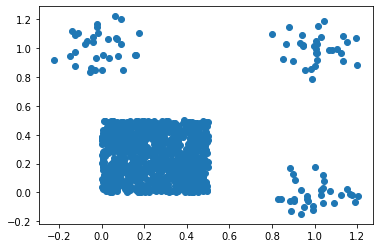

In [4]:
plt.scatter(*malanchev_dataset().T);

# Оценка средней длины пути в дереве

In [5]:
def _average_path_length(n):
    """
    Average path length formula.
    """
    return 2.0 * (np.log(n - 1.0) + np.euler_gamma) - 2.0 * (n - 1.0) / n


def average_path_length(n):
    """
    Average path length computation.
    Parameters
    ----------
    n
        Either array of tree depths to computer average path length of
        or one tree depth scalar.
    Returns
    -------
    Average path length.
    """
    if np.isscalar(n):
        if n <= 1:
            apl = 0
        elif n == 2:
            apl = 1
        else:
            apl = _average_path_length(n)
    else:
        n = np.asarray(n)
        apl = np.zeros_like(n)
        apl[n > 1] = _average_path_length(n[n > 1])
        apl[n == 2] = 1

    return apl

# Изоляционный лес

In [6]:
class IsolationForest:
    """
    Изоляционный лес
    """
    def __init__(self, trees=100, subsamples=256, depth=None, seed=0):
        self.subsamples = subsamples
        self.trees = trees
        self.depth = depth

        self.seedseq = np.random.SeedSequence(seed)
        self.rng = np.random.default_rng(seed)

        self.estimators = []
        self.n = 0

    def fit(self, data):
        n = data.shape[0]
        self.n = n
        self.subsamples = self.subsamples if n > self.subsamples else n

        self.depth = self.depth or int(np.ceil(np.log2(self.subsamples)))

        self.estimators = [None] * self.trees
        seeds = self.seedseq.spawn(self.trees)
        for i in range(self.trees):
            subs = self.rng.choice(n, self.subsamples)
            gen = IsolationForestGenerator(data[subs, :], self.depth, seeds[i])
            self.estimators[i] = gen.pine

        return self

    def mean_paths(self, data):
        means = np.zeros(data.shape[0])
        for ti in range(self.trees):
            path = self.estimators[ti].paths(data)
            means += path

        means /= self.trees
        return means

    def scores(self, data):
        means = self.mean_paths(data)
        return - 2 ** (-means / average_path_length(self.subsamples))


class Tree:
    "Дерево изоляционного леса"
    def __init__(self, features, selectors, values):
        self.features = features
        self.len = selectors.shape[0]

        # Two complementary arrays.
        # Selectors select feature to branch on.
        self.selectors = selectors
        # Values either set the deciding feature value or set the closing path length
        self.values = values

    def _get_one_path(self, key):
        i = 1
        while 2 * i < self.selectors.shape[0]:
            f = self.selectors[i]
            if f < 0:
                break

            if key[f] <= self.values[i]:
                i = 2 * i
            else:
                i = 2 * i + 1

        return self.values[i]

    def paths(self, x):
        n = x.shape[0]
        paths = np.empty(n)
        for i in range(n):
            paths[i] = self._get_one_path(x[i, :])

        return paths


class IsolationForestGenerator:
    "Выращивание деревьев в лесу"
    def __init__(self, sample, depth, seed=0):
        self.depth = depth
        self.features = sample.shape[1]
        self.length = 1 << (depth + 1)
        self.rng = np.random.default_rng(seed)
        self.selectors = np.full(self.length, -1, dtype=np.int32)
        self.values = np.full(self.length, 0, dtype=np.float64)

        self._populate(1, sample)

        self.pine = Tree(self.features, self.selectors, self.values)

    def _populate(self, i, sample):

        if sample.shape[0] == 1:
            self.values[i] = np.floor(np.log2(i))
            return

        if self.length <= 2 * i:
            self.values[i] = np.floor(np.log2(i)) + \
                             average_path_length(sample.shape[0])

            return

        selector = self.rng.integers(self.features)
        self.selectors[i] = selector

        minval = np.min(sample[:, selector])
        maxval = np.max(sample[:, selector])
        if minval == maxval:
            self.selectors[i] = -1
            self.values[i] = np.floor(np.log2(i)) + \
                average_path_length(sample.shape[0])

            return

        value = self.rng.uniform(minval, maxval)
        self.values[i] = value

        self._populate(2 * i, sample[sample[:, selector] <= value])
        self._populate(2 * i + 1, sample[sample[:, selector] > value])

# Ускорение вычисления очков изоляционным лесом

In [3]:
%%cython
# Добавьте к cython аргумент "-a" (annotate), чтобы посмотреть сгенерированный код


import numpy as np
from cython.parallel cimport prange, parallel

cimport numpy as np
cimport cython

cimport numpy as np


# Selector is the representation of decision tree nodes:
# either branches or leafs.
cdef packed struct selector_t:
    # Feature index to branch on
    np.int32_t feature
    # Index of left subtree
    np.int32_t left
    # Feature value to branch on
    np.float64_t value
    # Index of right subtree
    np.int32_t right

    # In case of leaf the fields have special values:
    # * feature == -1
    # * left == -1
    # * value == resulting decision score
    # * right == -1


# For bitness polymorphism
ctypedef fused floating:
    np.float32_t
    np.float64_t


def calc_mean_paths(selector_t [::1] selectors, np.int64_t [::1] indices, floating [:, ::1] data):
    cdef np.ndarray [np.double_t, ndim=1] paths = np.zeros(data.shape[0])
    cdef np.float64_t [::1] paths_view = paths
    cdef Py_ssize_t sellen = selectors.shape[0]

    if np.any(np.diff(indices) < 0):
        raise ValueError('indices should be an increasing sequence')

    if indices[-1] > sellen:
        raise ValueError('indices are out of range of the selectors')

    _mean_paths(selectors, indices, data, paths_view)
    return paths


@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _mean_paths(selector_t [::1] selectors,
                         np.int64_t [::1] indices,
                         floating [:, ::1] data,
                         np.float64_t [::1] paths):

    cdef Py_ssize_t trees
    cdef Py_ssize_t tree_index
    cdef Py_ssize_t x_index
    cdef selector_t selector
    cdef Py_ssize_t tree_offset
    cdef np.int32_t feature, i

    with nogil, parallel():
        trees = indices.shape[0] - 1

        for x_index in prange(data.shape[0], schedule='static'):
            for tree_index in range(trees):
                tree_offset = indices[tree_index]
                i = 0
                while True:
                    selector = selectors[tree_offset + i]
                    feature = selector.feature
                    if feature < 0:
                        break

                    if data[x_index, feature] <= selector.value:
                        i = selector.left
                    else:
                        i = selector.right

                paths[x_index] += selector.value

            paths[x_index] /= trees

In [23]:
class ForestEvaluator:
    selector_dtype = np.dtype([('feature', np.int32), ('left', np.int32), ('value', np.double), ('right', np.int32)])

    def __init__(self, samples, selectors, indices):
        """
        Base class for the forest evaluators. Does the trivial job:
        * runs calc_mean_paths written in cython,
        * helps to combine several trees' representations into two arrays.
        Parameters
        ----------
        samples
            Number of samples in every tree.
        selectors
            Array with all the nodes of all the trees.
        indices
            Indices of starting nodes of every tree.
        """
        self.samples = samples

        self.selectors = selectors
        self.indices = indices

    @classmethod
    def combine_selectors(cls, selectors_list):
        """
        Combine several node arrays into one array of nodes and one array of
        start indices.
        Parameters
        ----------
        selectors_list
            List of node arrays to combine.
        Returns
        -------
        Pair of two arrays: node array and array of starting indices.
        """
        lens = [len(sels) for sels in selectors_list]
        full_len = sum(lens)

        selectors = np.empty((full_len,), dtype=cls.selector_dtype)

        indices = np.empty((len(selectors_list) + 1,), dtype=np.int64)
        indices[0] = 0
        indices[1:] = np.add.accumulate(lens)

        for i in range(len(selectors_list)):
            selectors[indices[i]:indices[i + 1]] = selectors_list[i]

        return selectors, indices

    def score_samples(self, x):
        """
        Perform the computations.
        Parameters
        ----------
        x
            Features to calculate scores of. Should be C-contiguous for performance.
        Returns
        -------
        Array of scores.
        """
        if not x.flags['C_CONTIGUOUS']:
            x = np.ascontiguousarray(x)

        return -2 ** (- calc_mean_paths(self.selectors, self.indices, x) / average_path_length(self.samples))


class IsolationForestEvaluator(ForestEvaluator):
    "Построение специального вычислителя для подсчёта очков"
    def __init__(self, pine_forest):
        pines = pine_forest.estimators
        self.trees = len(pines)
        if self.trees < 1:
            raise ValueError('a forest without trees?')

        selectors, indices = self.combine_selectors(
            [self.extract_selectors(pine) for pine in pines])

        super(IsolationForestEvaluator, self).__init__(
            samples=pine_forest.subsamples,
            selectors=selectors,
            indices=indices)

    @classmethod
    def extract_selectors(cls, pine):
        selectors = np.zeros((pine.len,), dtype=cls.selector_dtype)

        mapping = np.full((pine.len,), -1, dtype=np.int32)
        current = 0
        for i in range(1, pine.len):
            if pine.selectors[i] != -1 or pine.values[i] != 0:
                mapping[i] = current
                current += 1

        selectors = selectors[:current]

        for i in range(1, pine.len):
            if pine.selectors[i] != -1 or pine.values[i] != 0:
                current = mapping[i]

                feature = pine.selectors[i]
                selectors[current]['feature'] = feature
                selectors[current]['value'] = pine.values[i]

                if 2 * i >= pine.len:
                    continue

                selectors[current]['left'] = mapping[2 * i]
                selectors[current]['right'] = mapping[2 * i + 1]

        return selectors

# Пример

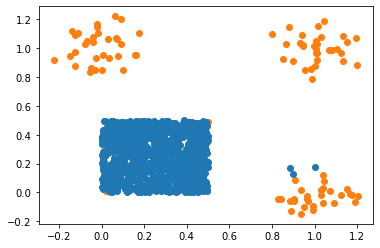

In [8]:
data = malanchev_dataset()
isoforest = IsolationForest(trees=100, subsamples=16, depth=4)
isoforest.fit(data)
scores = isoforest.scores(data)
sorting = np.argsort(scores)

plt.scatter(*data[sorting[:96]].T, color='C1')
plt.scatter(*data[sorting[96:]].T, color='C0')
pass

# Тесты

In [9]:
data = malanchev_dataset(inliers=2**13)

In [10]:
%%time
isoforest = IsolationForest(trees=200, subsamples=1024, depth=10)
isoforest.fit(data)
pass

CPU times: user 1.99 s, sys: 7.79 ms, total: 2 s
Wall time: 1.99 s


In [15]:
evaluator = IsolationForestEvaluator(isoforest)

In [22]:
%%time
scores = evaluator.score_samples(data)

CPU times: user 263 ms, sys: 2 ms, total: 265 ms
Wall time: 263 ms


In [28]:
# При экстраполяции на 10e6 точек:
0.263 / 2**13 * 10e6

321.044921875